In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import re, os

## Scraping Linkedin data

In this project, we want to scrape some LinkedIn profiles, and store name, title, location and profile picture. We will make use of Selenium and BeautifulSoup.

### Authenticaton

In [4]:
# Note that you may need to solve a captcha or double authenticate
email = "email"
password = "password"

In [5]:
service = webdriver.chrome.service.Service(executable_path="/Users/lin/Documents/stages/assessment/Divercity/chromedriver")
driver = webdriver.Chrome(service=service)

driver.get('https://www.linkedin.com/login')
time.sleep(3)
driver.find_element(value='username').send_keys(email)
driver.find_element(value='password').send_keys(password + Keys.RETURN)

### Getting the profiles

We will scrape 100 profiles from the employees at Hubspot. The approach was to navigate to the employees tab and scrape from there. However it may be more reliable and "safer" (not to get paywalled) to scrape from the "People" section by scrolling to the bottom. Scrolling is needed for the data to load.

Note that the times are hardcoded, you will have to adapt them to your internet connection speed or wait dynamically for the page to load.

In [11]:
driver.get("https://www.linkedin.com/company/hubspot/")
time.sleep(3)

In [ ]:
# This cell may not work due to different page layout for different profiles.
# Just skip this cell and click on the employees link for now 
pos = driver.find_element(by=By.XPATH,value='//div[@class="display-flex mt2 mb1"]')
h = pos.find_element(by=By.CSS_SELECTOR, value="a")
h.click()
time.sleep(3)

In [14]:
df = pd.DataFrame(columns=["FirstName", "LastName", "Label", "Location"])

page = 1
maxPage = int(driver.find_elements(by=By.XPATH,value=f'//li[@data-test-pagination-page-btn]')[-1].get_attribute("data-test-pagination-page-btn"))
numProfiles = 100
i = 0

driver.execute_script(f"window.scrollTo({0},{1000})")
time.sleep(0.5)

while i < numProfiles and page < maxPage :
    src = driver.page_source
    soup = BeautifulSoup(src, "html")
    res = soup.find_all("div", {'class': 'entity-result'})
    for elem in res :
        name = elem.find_all(class_="visually-hidden")
        if name :
            if "status is " in name[0].get_text().lower() :
                if len(name) > 1 :
                    nameStr = re.sub("^View\s|’+.*", "", name[1].get_text())
                else :
                    continue
            else :
                nameStr = name[0].get_text()
            # Remove the text in parenthesis and titles after a comma
            nameStr = re.sub("\s+", " ", re.sub("\(+.*?\)+|,+.*", "", nameStr).strip())
            firstName, lastName = nameStr.rsplit(" ", 1)

            df.loc[i] = [firstName, lastName, elem.find("div", {"class" : "entity-result__primary-subtitle"}).get_text().strip(), \
                elem.find("div", {"class" : "entity-result__secondary-subtitle"}).get_text().strip()]

            # Some profiles may not have a profile picture
            try :
                urllib.request.urlretrieve(elem.find("img")["src"], f"./pics/dummy/{i}.png")
            except :
                pass
            
            i += 1

            if i == numProfiles :
                break

    page += 1
    pos = driver.find_element(by=By.XPATH,value=f'//button[@aria-label="Next"]')
    pos.click()
    time.sleep(3)
    driver.execute_script(f"window.scrollTo({0},{600})")

df.to_csv("results.csv", index=False)
driver.quit()

## Gender classification

After scraping the profiles let's build an image classifier for the genders. To do that we use the Kaggle [CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), where we extracted only the gender. The files are located in the celebs folder.

In [2]:
from typing import Type, Any, Callable, Union, List, Optional
import torch
import torch.nn as nn
from torch import Tensor
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

### Defining the model

In [3]:
"""
ResNet model taken from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
"""

def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;
    Args:
        obj (class instance or method): an object to extract info from.
    """
    if not obj.__module__.startswith("torchvision"):
        return
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{obj.__module__}.{name}")

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(BasicBlock, [2, 2, 2, 2], progress, **kwargs)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet18(num_classes=2).to(device)

### Loading the data

Although for us as humans, the CelebA dataset looks similar to the scrapped profile pictures, it is not the case for the computer. Only cropping to the center window leads to quite bad performances. This is probably due to the quality of the pictures being different. That's why we have to introduce some random trasformations, for the model to be more robust.

In [5]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(100),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(100),
                                     transforms.ToTensor()])

# train_transforms = transforms.Compose([transforms.CenterCrop(100),
#                                        transforms.ToTensor()])

# test_transforms = transforms.Compose([transforms.CenterCrop(100),
#                                        transforms.ToTensor()])

In [6]:
# Pass transforms in here, then run the next cell to see how the transforms look
data_dir = "celebs"
train_data = datasets.ImageFolder(data_dir + '/Training', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/Testing', transform=test_transforms)

bs = 128
trainloader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=bs)
valloader = torch.utils.data.DataLoader(val_data, batch_size=bs)

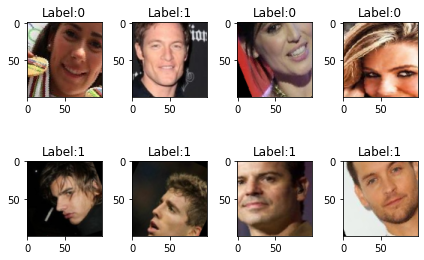

In [7]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
for ii in range(8):
    plt.subplot(2,4,ii+1)
    plt.imshow(np.transpose(images[ii],(1,2,0)))
    plt.title(f"Label:{labels[ii].item()}")
plt.tight_layout()

### Training the model

In [7]:
def train(model, trainloader, loss_fn, optimizer, losses) :
    model.train()
    pbar = tqdm(total=len(trainloader), leave=False)
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        pbar.update(1)
        pbar.set_postfix({"Loss":loss.item()})
    
    pbar.close()

def test(model, testloader, loss_fn_test) :
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        pbar = tqdm(total=len(testloader), leave=False)
        for data, target in testloader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += loss_fn_test(output, target).item()  # sum up batch loss
            pred = torch.argmax(output, axis=1)
            correct += (pred == target).sum().item()

            pbar.update(1)
            pbar.set_postfix({"Acc":(pred == target).sum().div(len(data)).item()})
            
        pbar.close()
    
    return test_loss

def train_model(model, epochs, loss_fn, loss_fn_test, optimizer, trainloader, valloader, testloader=False, early_stop_tol=5, savePath=f"best_model_{bs}.pt") :
    losses, val_losses, test_losses = [], [], []

    cnt = 0 # succesive iterations without validation loss increase
    best_loss = np.inf
    for _ in trange(epochs):

        train(model, trainloader, loss_fn, optimizer, losses)

        val_loss = test(model, valloader, loss_fn_test)
        val_losses.append(val_loss)
        if best_loss > val_loss :
            best_loss = val_loss
            torch.save(model.state_dict, savePath)
            cnt = 0
        else :
            cnt += 1
            if cnt > early_stop_tol :
                break
        
        if testloader is not None :
            test_loss = test(model, testloader, loss_fn_test)
            test_losses.append(test_loss)
    
    return losses, val_losses, test_losses if testloader is not None else losses, val_losses

In [9]:
loss_fn = nn.CrossEntropyLoss()
loss_fn_test = nn.CrossEntropyLoss(reduction="sum")
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Warning : the traning can be long, usually stops around 20 epochs.
# Took a few hours with GPU
# Skip to the next section if you just want to play with the trained model
losses, val_losses, test_losses = train_model(model, 100, loss_fn, loss_fn_test, optimizer, trainloader, valloader, testloader)

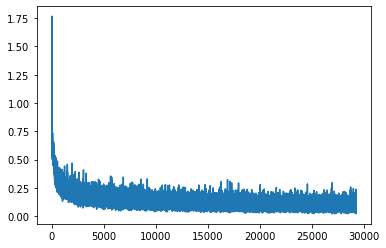

In [18]:
plt.plot(losses)

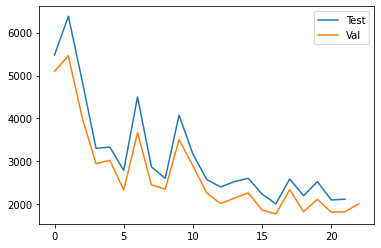

In [19]:
plt.plot(test_losses, label="Test")
plt.plot(val_losses, label="Val")
plt.legend()

### Loading and testing the best model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = resnet18(num_classes=2)
if torch.cuda.is_available() :
    device = "cuda"
    model2.to(device)
    model2.load_state_dict(torch.load("final_model.pt"))
else :
    device = "cpu"
    model2.load_state_dict(torch.load("final_model.pt", map_location=torch.device('cpu')))

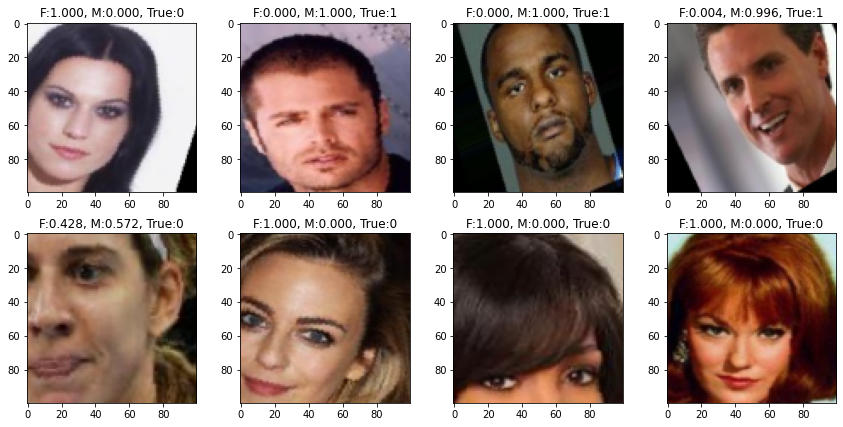

In [9]:
for _, (data,lab) in enumerate(trainloader) :
    break

probs = nn.Softmax(dim=1)(model2(data.to(device)))
plt.figure(figsize=(12,6))
for i in range(len(data)) :
    plt.subplot(2,4,i+1)
    plt.title(f"F:{probs[i][0]:.3f}, M:{probs[i][1]:.3f}, True:{lab[i]}")
    plt.imshow(np.transpose(data[i],(1,2,0)))
    
    if i >= 7 :
        break
plt.tight_layout()

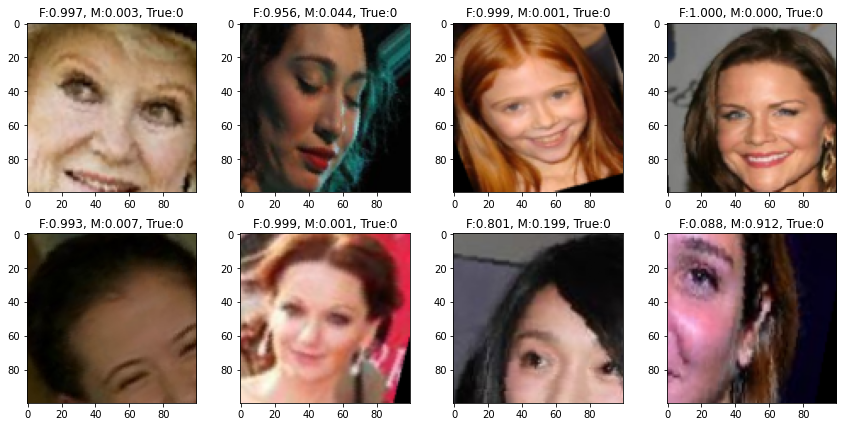

In [10]:
for _, (data,lab) in enumerate(testloader) :
    break

probs = nn.Softmax(dim=1)(model2(data.to(device)))
plt.figure(figsize=(12,6))
for i in range(len(data)) :
    plt.subplot(2,4,i+1)
    plt.title(f"F:{probs[i][0]:.3f}, M:{probs[i][1]:.3f}, True:{lab[i]}")
    plt.imshow(np.transpose(data[i],(1,2,0)))
    
    if i >= 7 :
        break
plt.tight_layout()

### Predicting the genders

Curiously, using a center crop yield worse results than with the same tranformations as the testing set; the model has probably leant some spurious correlations. In particular, it seems to be confused a lot by the uniform colored backgrounds and a bit by the banners in the profile picture.

In [12]:
test_transforms2 = transforms.Compose([transforms.CenterCrop(100),
                                       transforms.ToTensor()])

#test_data2 = datasets.ImageFolder("pics", transform=test_transform2)
test_data2 = datasets.ImageFolder("pics", transform=test_transforms) # test_tranforms in loading the data section
testloader2 = torch.utils.data.DataLoader(test_data2, batch_size=128)

To compute the accuracy, we hand labelled the data.

In [13]:
labs = [0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0]

In [18]:
for _, (data,_) in enumerate(testloader2) :
    break

probs = nn.Softmax(dim=1)(model2(data.to(device)))
(probs.argmax(axis=1) == torch.tensor(labs).to(device)).float().mean().item()

0.8421052694320679

Accuracy : 0.8315789699554443


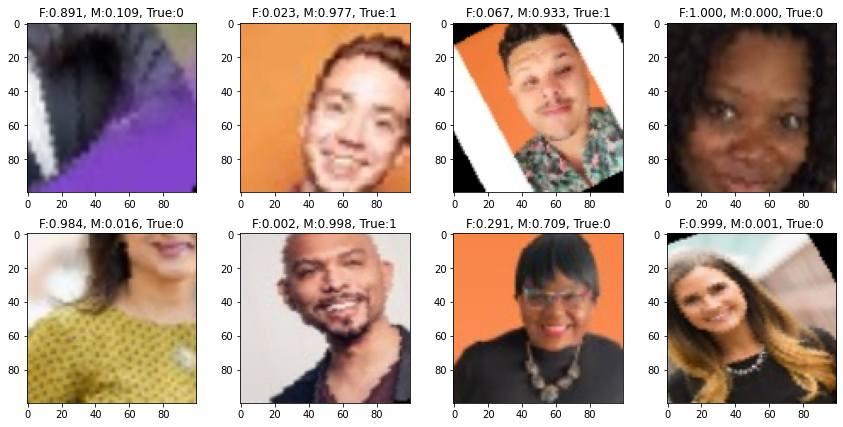

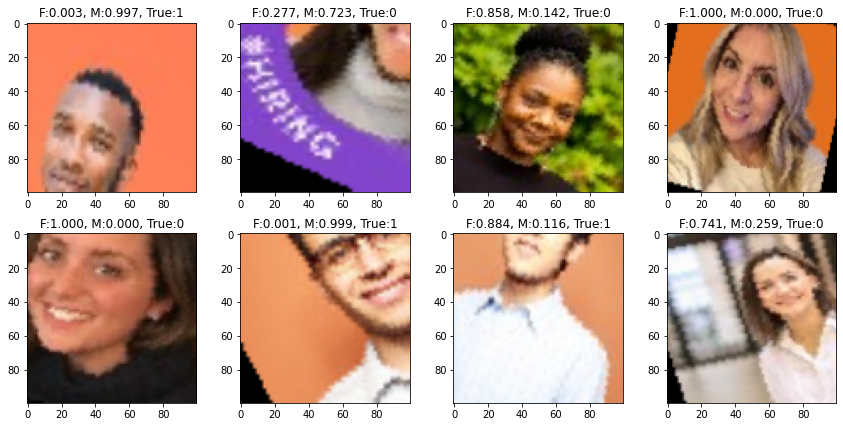

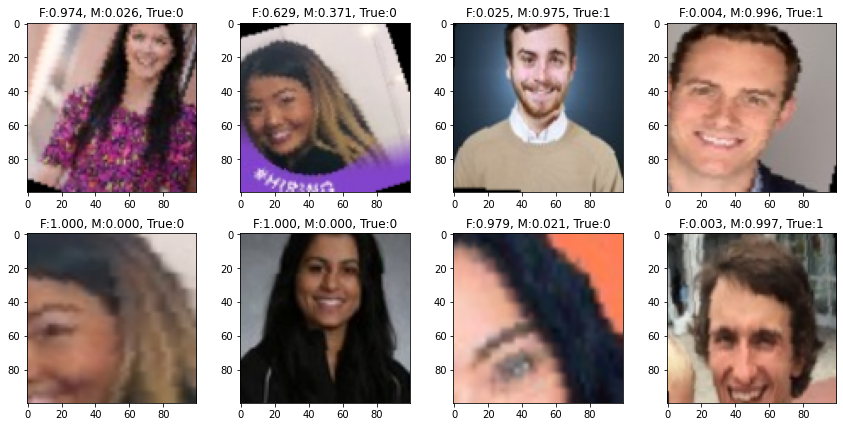

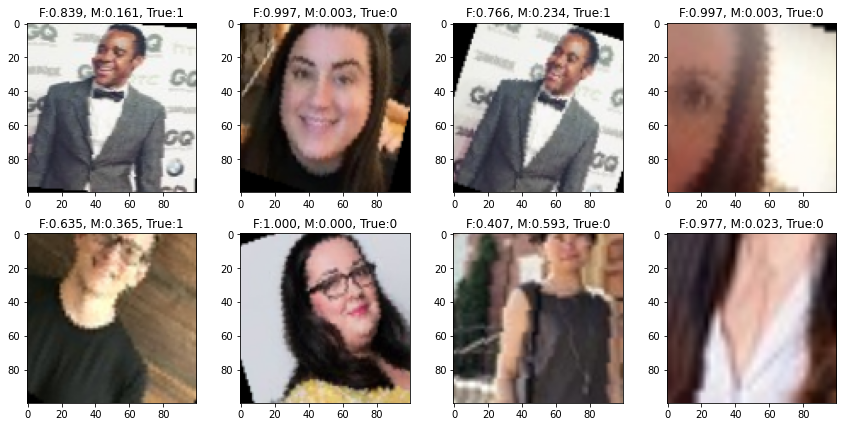

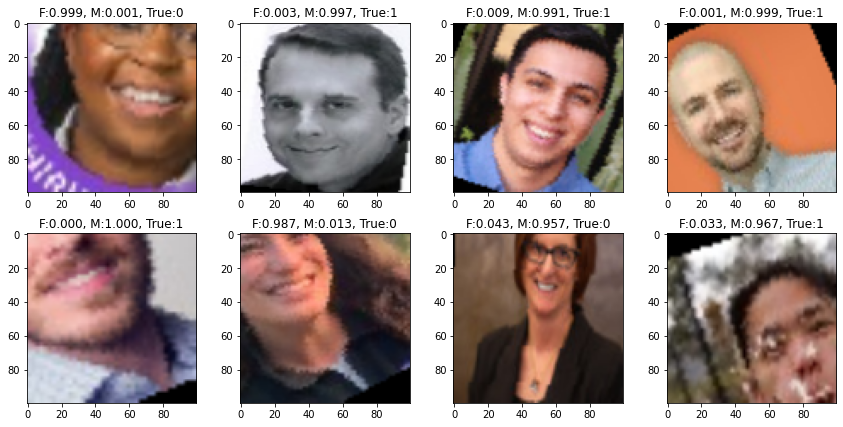

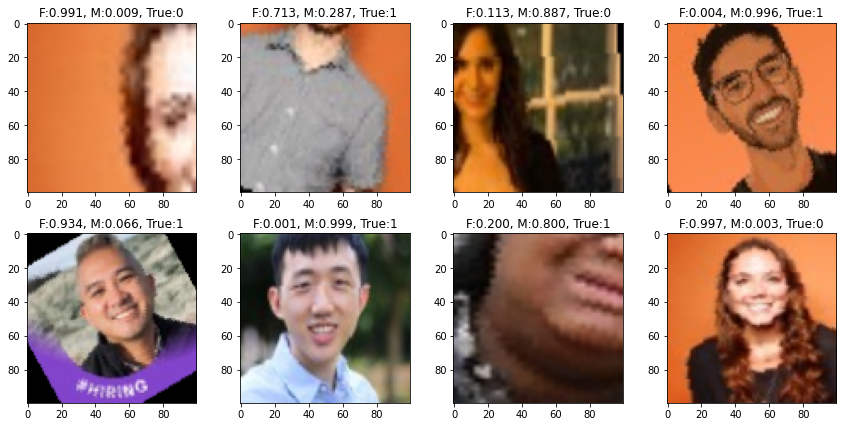

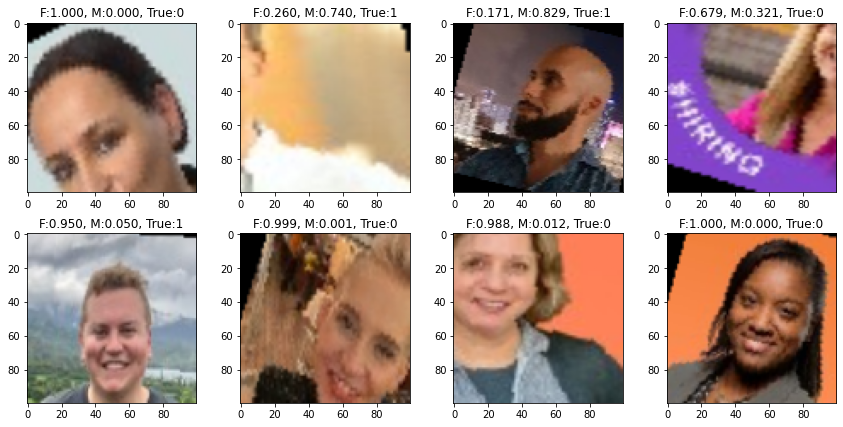

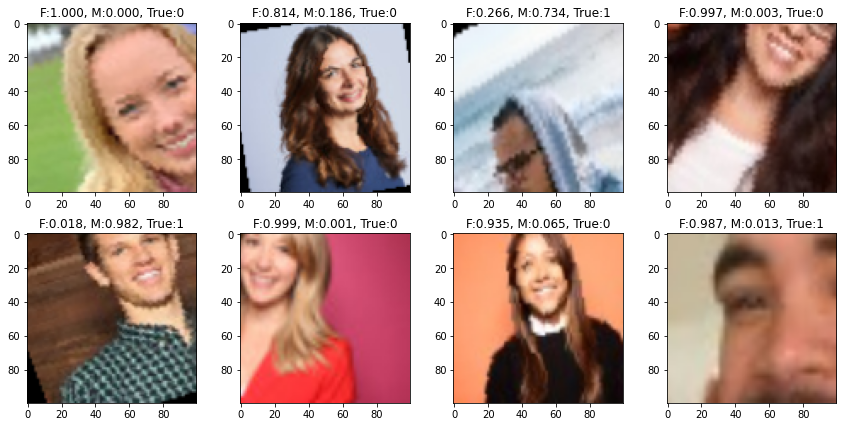

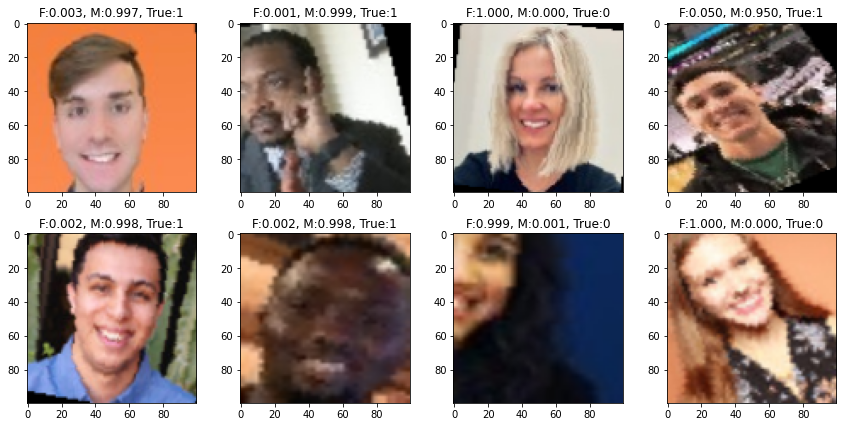

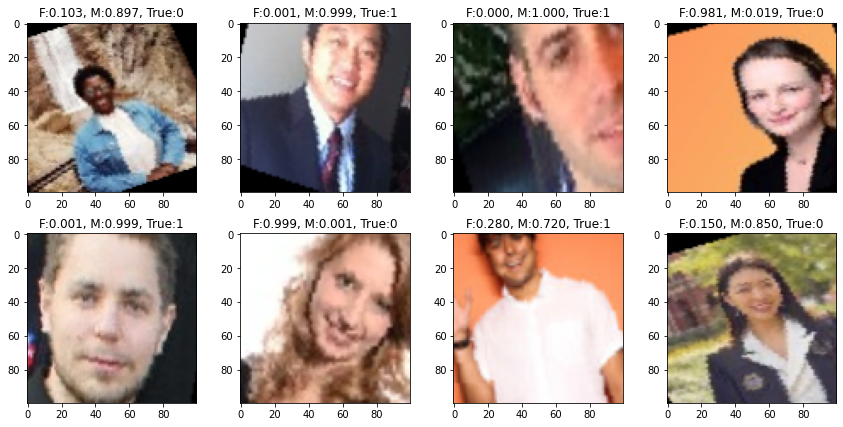

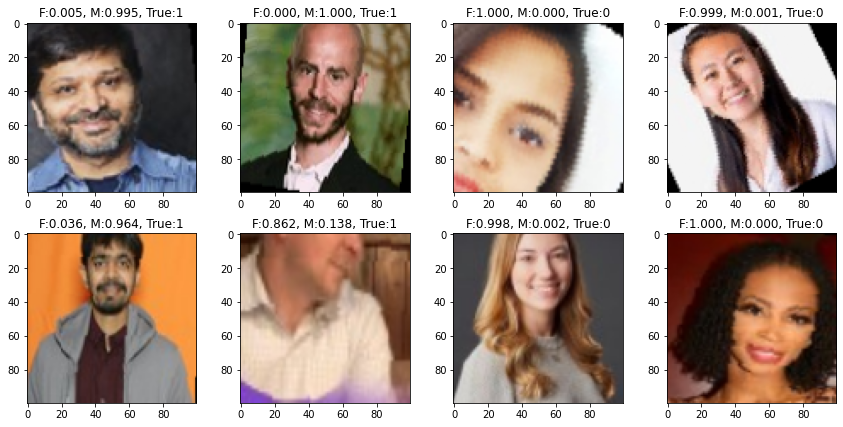

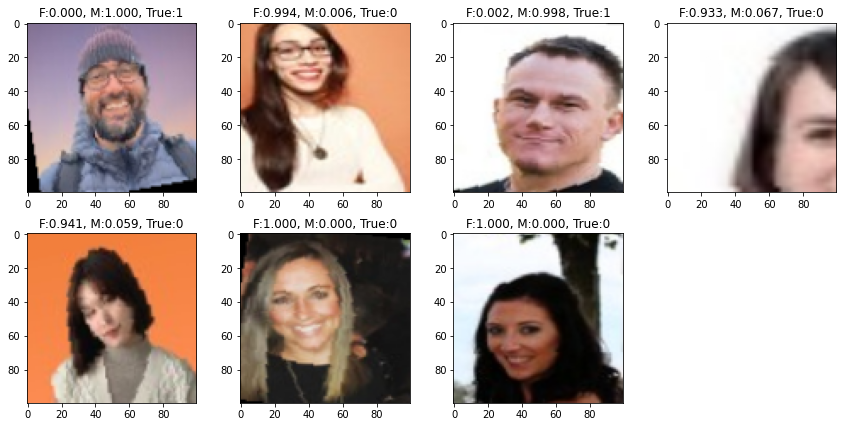

In [19]:
for _, (data,lab) in enumerate(testloader2) :
    break

probs = nn.Softmax(dim=1)(model2(data.to(device)))
print(f"Accuracy : {(probs.argmax(axis=1) == torch.tensor(labs).to(device)).float().mean()}")
for i in range(len(data)) :
    if i % 8 == 0 :
        plt.figure(figsize=(12,6))

    plt.subplot(2,4,i%8+1)
    plt.title(f"F:{probs[i][0]:.3f}, M:{probs[i][1]:.3f}, True:{labs[i]}")
    plt.imshow(np.transpose(data[i],(1,2,0)))
    
    if i % 8 == 7 :
        plt.tight_layout()
        plt.show()

plt.tight_layout()
plt.show()

Now we just need to save the results.

In [21]:
names = sorted(p for p in os.listdir("pics/dummy") if not p.startswith('.'))
names = list(map(lambda x:int(re.sub("\.+.*", "", x)), names))
results = pd.read_csv("results.csv")

In [24]:
pred = probs.argmax(axis=1).cpu().numpy()
gender = ["N/A"] * len(results)
for i in range(len(names)) :
    gender[names[i]] = "F" if pred[i] else "M"

results["gender"] = gender
results.to_csv("results.csv", index=False)